# Data Preparation and Advanced Model Evaluation
---

## Agenda

**Data preparation**

- Handling missing values
- Handling categorical features (review)

**Advanced model evaluation**

- ROC curves and AUC
- Bonus: ROC curve is only sensitive to rank order of predicted probabilities
- Cross-validation

## Part 1: Handling missing values

scikit-learn models expect that all values are **numeric** and **hold meaning**. Thus, missing values are not allowed by scikit-learn.

In [1]:
# read the Titanic data
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
titanic = pd.read_csv(url, index_col='PassengerId')
titanic.shape

(891, 11)

In [2]:
# check for missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

One possible strategy is to **drop missing values**:

In [3]:
# drop rows with any missing values
titanic.dropna().shape

(183, 11)

In [ ]:
# drop rows where Age is missing
titanic[titanic.Age.notnull()].shape

Sometimes a better strategy is to **impute missing values**:

In [4]:
# mean Age
titanic.Age.mean()

29.69911764705882

In [5]:
# median Age
titanic.Age.median()

28.0

In [6]:
# most frequent Age
titanic.Age.mode()

0    24.0
dtype: float64

In [7]:
# fill missing values for Age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

Another strategy would be to build a **KNN model** just to impute missing values. How would we do that?

If values are missing from a categorical feature, we could treat the missing values as **another category**. Why might that make sense?

How do we **choose** between all of these strategies?

## Part 2: Handling categorical features (Review)

How do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

In [8]:
titanic.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [9]:
# encode Sex_Female feature
titanic['Sex_Female'] = titanic.Sex.map({'male':0, 'female':1})

In [10]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [11]:
titanic.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Female,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,0.0,1.0


- How do we **interpret** the encoding for Embarked?
- Why didn't we just encode Embarked using a **single feature** (C=0, Q=1, S=2)?
- Does it matter which category we choose to define as the **baseline**?
- Why do we only need **two dummy variables** for Embarked?

In [13]:
# define X and y
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

# train/test split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# train a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e4)
logreg.fit(X_train, y_train)

# make predictions for testing set
y_pred_class = logreg.predict(X_test)

# calculate testing accuracy
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.793721973094


## Part 3: ROC curves and AUC

In [14]:
# predict probability of survival
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

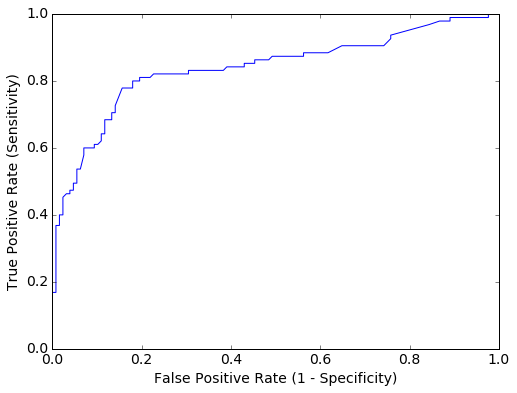

In [16]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [17]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)

0.838692434211


Besides allowing you to calculate AUC, seeing the ROC curve can help you to choose a threshold that **balances sensitivity and specificity** in a way that makes sense for the particular context.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118769050>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119370150>], dtype=object)

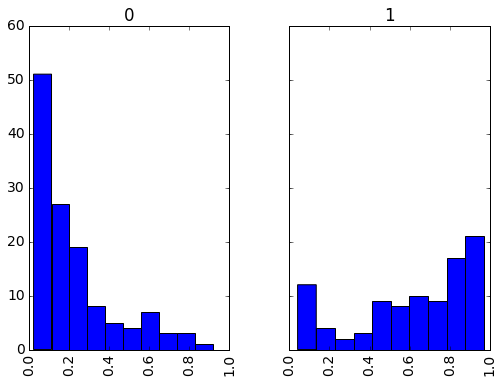

In [18]:
# histogram of predicted probabilities grouped by actual response value
df = pd.DataFrame({'probability':y_pred_prob, 'actual':y_test})
df.hist(column='probability', by='actual', sharex=True, sharey=True)

What would have happened if you had used **y_pred_class** instead of **y_pred_prob** when drawing the ROC curve or calculating AUC?

In [ ]:
# ROC curve using y_pred_class - WRONG!
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
plt.plot(fpr, tpr)

In [ ]:
# AUC using y_pred_class - WRONG!
print metrics.roc_auc_score(y_test, y_pred_class)

If you use **y_pred_class**, it will interpret the zeros and ones as predicted probabilities of 0% and 100%.

## Bonus: ROC curve is only sensitive to rank order of predicted probabilities

In [ ]:
# print the first 10 predicted probabilities
y_pred_prob[:10]

In [ ]:
# take the square root of predicted probabilities (to make them all bigger)
import numpy as np
y_pred_prob_new = np.sqrt(y_pred_prob)

# print the modified predicted probabilities
y_pred_prob_new[:10]

In [ ]:
# histogram of predicted probabilities has changed
df = pd.DataFrame({'probability':y_pred_prob_new, 'actual':y_test})
df.hist(column='probability', by='actual', sharex=True, sharey=True)

In [ ]:
# ROC curve did not change
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_new)
plt.plot(fpr, tpr)

In [ ]:
# AUC did not change
print metrics.roc_auc_score(y_test, y_pred_prob_new)

## Part 4: Cross-validation

In [ ]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

In [ ]:
# add Fare to the model
feature_cols = ['Pclass', 'Parch', 'Age', 'Sex_Female', 'Embarked_Q', 'Embarked_S', 'Fare']
X = titanic[feature_cols]

# recalculate AUC
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()